In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from typing import Sequence
import itertools

### Data preparation

I used small enough data to fit it in my computer RAM and with small computational time.

In [2]:
!pip3 install -q gdown
import gdown

In [3]:
url = 'https://drive.google.com/file/d/1M9dk8Ka4LRm-z99vkQoPJwuQv2Iq8WOh/view?usp=drive_link'
output = 'book_small.csv'
gdown.download(url, output, quiet=False, fuzzy=True)

url = 'https://drive.google.com/file/d/129saQzGCZpi3phu60TV2UtJ6LQRDWuyp/view?usp=drive_link'
output = 'ticker_small.csv'
gdown.download(url, output, quiet=False, fuzzy=True)

url = 'https://drive.google.com/file/d/1YdQCthUV7ElsrwdTVo8uR9HsXH236vUm/view?usp=drive_link'
output = 'trades_small.csv'
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1M9dk8Ka4LRm-z99vkQoPJwuQv2Iq8WOh
To: /kaggle/working/book_small.csv
100%|██████████| 76.6M/76.6M [00:00<00:00, 127MB/s] 
Downloading...
From: https://drive.google.com/uc?id=129saQzGCZpi3phu60TV2UtJ6LQRDWuyp
To: /kaggle/working/ticker_small.csv
100%|██████████| 70.3M/70.3M [00:00<00:00, 215MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1YdQCthUV7ElsrwdTVo8uR9HsXH236vUm
To: /kaggle/working/trades_small.csv
100%|██████████| 16.0M/16.0M [00:00<00:00, 110MB/s] 


'trades_small.csv'

In [5]:
book_small = pd.read_csv('book_small.csv', index_col=0)
ticker_small = pd.read_csv('ticker_small.csv', index_col=0)
trades_small = pd.read_csv('trades_small.csv', index_col=0)

In [6]:
trades_small['remote_ts'] *= 10**6 # convert to one dimension
ticker_small['remote_ts'] *= 10**6

In [7]:
ticker_small = ticker_small.sort_values('remote_ts')
bid_prices = ticker_small['bid_price'].values
ask_prices = ticker_small['ask_price'].values

In [8]:
mid_prices = (bid_prices + ask_prices) / 2
realized_sigma = ((mid_prices[1:] - mid_prices[:-1])**2).sum()**0.5
realized_sigma

79.4071155501805

#### 1) LimitOrder class for limit orders handling. 
#### 2) PriceLevel class needs to save info what orders and in which order were placed at this price level. Also it match orders using rule first come - first serve 

In [9]:
MARKET_ID: int = 0
MM_ID: int = 1

BUY: int = 0
SELL: int = 1

class LimitOrder:
    def __init__(self, price: float, amount: float, side: int, trader_id: int):
        price = round(price, 1)
        amount = round(amount, 3)
        assert amount > 0
        assert price >= 0

        self.price = price
        self.amount = amount
        self.side = side
        self.trader_id = trader_id
    
    def __repr__(self):
        return f'LimitOrder({self.price}, {self.amount}, {self.side}, {self.trader_id})'


class PriceLevel:
    def __init__(self, first_limit_order: LimitOrder):
        self.price = first_limit_order.price
        self.amount = first_limit_order.amount
        self.side = first_limit_order.side
        self.traders_order = [first_limit_order]
    
    def __repr__(self):
        return f'PriceLevel({self.price}, {self.amount}, {self.side})'

    def add_limit_order(self, limit_order: LimitOrder): # trader_id: 0 - market, 1 - MM
        assert limit_order.price == self.price
        assert limit_order.side == self.side

        self.amount += limit_order.amount
        self.amount = round(self.amount, 3)
        if len(self.traders_order):
            if limit_order.trader_id == self.traders_order[-1].trader_id:
                self.traders_order[-1].amount += limit_order.amount
                self.traders_order[-1].amount = round(self.traders_order[-1].amount, 3)
            else:
                self.traders_order.append(limit_order)
        else:
            self.traders_order.append(limit_order)
        
    def eat_price_level(self, amount: float):
        remain_amount = round(amount, 3)
        match_info = defaultdict(int) # trader_id - amount_sold

        for i, limit_order in enumerate(self.traders_order):
            match_info[limit_order.trader_id] += min(limit_order.amount, remain_amount)
            self.amount -= min(limit_order.amount, remain_amount)

            if remain_amount < limit_order.amount:
                limit_order.amount -= remain_amount
                limit_order.amount = round(limit_order.amount, 3)
                self.traders_order = [limit_order] + self.traders_order[i+1:]
                remain_amount = 0
                break
            else:
                remain_amount -= limit_order.amount
        
        remain_amount = round(remain_amount, 3)
        self.amount = round(self.amount, 3)
        if self.amount == 0:
            self.traders_order = []

        return remain_amount, match_info

#### 1) Matching Engine - to match limit orders

#### 2) OrderBook - saves sorted asks and bids and sets new limit orders 

In [10]:
def read_state(state):
    '''to convert ob state from pandas Dataframe line
    to OrderBook state'''
    bids = []
    asks = []

    for i in range(25):
        amount = state[f'asks[{i}].amount']
        price = state[f'asks[{i}].price']
        asks.append(PriceLevel(LimitOrder(price, amount, SELL, MARKET_ID)))

        amount = state[f'bids[{i}].amount']
        price = state[f'bids[{i}].price']
        bids.append(PriceLevel(LimitOrder(price, amount, BUY, MARKET_ID)))
    
    asks.sort(key=lambda x: x.price)
    bids.sort(key=lambda x: -x.price)

    return bids, asks

class MatchingEngine:
    def __init__(self):
        pass 
    
    @staticmethod
    def match_orders(price_levels: Sequence[PriceLevel], amount: float):
        remain_amount = amount
        price: float = 0.0
        remain_orders = []
        matches_info = defaultdict(list) # trader_info - [amount, price]

        for i, price_level in enumerate(price_levels):
            this_price: float = price_level.price
            this_amount: float = price_level.amount
            price += this_price * min(remain_amount, this_amount)
            remain_amount, this_match_info = price_level.eat_price_level(remain_amount)

            for k, v in this_match_info.items():
                trader_info = matches_info[k]
                if len(trader_info):
                    trader_info[0] += v
                    trader_info[1] += v * this_price
                else:
                    trader_info = [v, v * this_price]
                matches_info[k] = trader_info

            if not remain_amount:
                if price_level.amount:
                    remain_orders += [price_level]
                remain_orders += price_levels[i+1:]
                break

        return matches_info, remain_orders, remain_amount


class OrderBook:
    def __init__(self, bids: Sequence[PriceLevel] = [], asks: Sequence[PriceLevel] = [], 
                 matching_engine: MatchingEngine = MatchingEngine()):
        self.bids = bids
        self.asks = asks
        self.matching_engine = matching_engine
    
    def __repr__(self):
        ob_repr = ''

        for bid in self.bids[::-1]:
            ob_repr += repr(bid)

        for ask in self.asks:
            ob_repr += repr(ask)
        
        return ob_repr

    def load_state(self, state):
        bids, asks = read_state(state)
        
        self.asks = asks
        self.bids = bids

        return self
    
    def get_state(self):
        return self.bids, self.asks
    
    def get_bids(self):
        return self.bids
    
    def get_asks(self):
        return self.asks
    
    def bid_price(self):
        return self.bids[0].price

    def ask_price(self):
        return self.asks[0].price

    def mid_price(self):
        return (self.bids[0].price + self.asks[0].price) / 2

    def bid_ask_spread(self):
        return self.asks[0].price - self.bids[0].price

    def market_depth(self):
        return self.asks[-1].price - self.bids[-1].price
    
    def set_ask_order(self, limit_order: LimitOrder):
        index = len(self.bids)
        for i, price_level in enumerate(self.bids):
            if price_level.price < limit_order.price:
                index = i
                break

        eligible_bids = self.bids[:index]
        ineligible_bids = self.bids[index:]

        matches_info, remain_bids, remain_amount = self.matching_engine.match_orders(eligible_bids, limit_order.amount)
        new_bids: Sequence[PriceLevel] = remain_bids + ineligible_bids
        new_asks: Sequence[PriceLevel] = self.asks

        if remain_amount > 0:
            new_limit_order = LimitOrder(limit_order.price, remain_amount, 
                                         limit_order.side, limit_order.trader_id)

            index = len(new_asks)
            for i, price_level in enumerate(new_asks):
                if price_level.price >= limit_order.price:
                    index = i
                    break

            if index == len(new_asks):
                new_asks.append(PriceLevel(new_limit_order))
            elif new_asks[index].price != limit_order.price:
                new_asks.insert(index, PriceLevel(new_limit_order))
            else:
                new_asks[index].add_limit_order(new_limit_order)
        
        self.bids = new_bids
        self.asks = new_asks

        return matches_info
    
    def set_bid_order(self, limit_order: LimitOrder):
        index = len(self.asks)
        for i, price_level in enumerate(self.asks):
            if price_level.price > limit_order.price:
                index = i
                break
 
        eligible_asks = self.asks[:index]
        ineligible_asks = self.asks[index:]

        matches_info, remain_asks, remain_amount = self.matching_engine.match_orders(eligible_asks, limit_order.amount)
        new_asks: Sequence[PriceLevel] = remain_asks + ineligible_asks
        new_bids: Sequence[PriceLevel] = self.bids

        if remain_amount > 0:
            new_limit_order = LimitOrder(limit_order.price, remain_amount, 
                                         limit_order.side, limit_order.trader_id)

            index = len(new_bids)
            for i, price_level in enumerate(new_bids):
                if price_level.price <= limit_order.price:
                    index = i
                    break
            
            if index == len(new_bids):
                new_bids.append(PriceLevel(new_limit_order))
            elif new_bids[index].price != limit_order.price:
                new_bids.insert(index, PriceLevel(new_limit_order))
            else:
                new_bids[index].add_limit_order(new_limit_order)
        
        self.bids = new_bids
        self.asks = new_asks

        return matches_info

    def set_order(self, limit_order: LimitOrder):
        if limit_order.side == SELL:
            matches_info = self.set_ask_order(limit_order)
        elif limit_order.side == BUY:
            matches_info = self.set_bid_order(limit_order)
        else:
            raise Exception("WRONG SIDE!")
        
        return matches_info

#### Avellaneda-Stoikov strategy implementation

Agent class needed just to store info abount my balance

In [11]:
class AvellanedaStoikov:
    def __init__(self, T: float, t_start: float, q0: float = 0, k: float = 1.5, 
                 sigma: float = 2, gamma: float = 0.1, q_max: float = 10**5):
        self.T = T
        self.t_start = t_start
        self.q0 = q0
        self.k = k
        self.sigma = sigma
        self.gamma = gamma
        self.q_max = q_max 

        self.q = self.q0

    def get_indifference_price(self, mid_price: float, timestamp):
        if timestamp > self.T:
            raise Exception("Time for trading is over")
        
        r = mid_price - self.q * self.gamma * self.sigma**2 * (self.T - timestamp) / (self.T - self.t_start)
        return r
    
    def get_optimal_spread(self, timestamp):
        if timestamp > self.T:
            raise Exception("Time for trading is over")
        
        optimal_spread = self.gamma * self.sigma**2 * (self.T - timestamp) / (self.T - self.t_start) + \
                         2 / self.gamma * np.log1p(self.gamma / self.k)

        return optimal_spread
        
    def update_inventory(self, q: float):
        self.q = q
    
    def get_bid_ask_price(self, lob_state: OrderBook, timestamp):
        r = self.get_indifference_price(lob_state.mid_price(), timestamp)
        optimal_spread = self.get_optimal_spread(timestamp)

        bid_price = r - optimal_spread / 2
        ask_price = r + optimal_spread / 2

        bid_price = np.round(bid_price, 1)
        ask_price = np.round(ask_price, 1)
    
        return bid_price, ask_price
    
    def bid_ask_limit_orders(self, lob_state: OrderBook, timestamp, q = None):
        if q is not None:
            self.update_inventory(q)
        bid_price, ask_price = self.get_bid_ask_price(lob_state, timestamp)

        bid_order = LimitOrder(bid_price, self.q_max, BUY, MM_ID)
        ask_order = LimitOrder(ask_price, self.q_max, SELL, MM_ID)

        return bid_order, ask_order

class Agent:
    def __init__(self, alpha, BTC: float, USDT: float):
        self.alpha = alpha
        self.BTC = BTC
        self.USDT = USDT
    
    def __repr__(self):
        return f'{self.BTC}-{self.USDT}'

    def set_bid_ask(self, lob_state: OrderBook, timestamp):
        bid_order, ask_order = self.alpha.bid_ask_limit_orders(lob_state, timestamp, self.BTC)
        return bid_order, ask_order

#### In lob data often some difference between two sequential lob states, even with accounting history matched trades. Thus, I considered - if some orders appeared, then I need to simulate their as new limit orders arrived to my lob. And if some orders dissapeared, than someone canceled them.

In [12]:
def get_unmatched_history_orders(lob1: OrderBook,
                             lob2: OrderBook):
    '''finding difference in lob states '''
    asks1 = lob1.get_asks()
    asks2 = lob2.get_asks()

    index = 0
    asks_orders = []
    if len(asks2):
        for ask in asks1:
            while (ask.price > asks2[index].price) and ((index + 1) < len(asks2)):
                index += 1
            
            if ask.price == asks2[index].price:
                if ask.amount > asks2[index].amount:
                    asks_orders.append(LimitOrder(ask.price, ask.amount - asks2[index].amount, ask.side, MARKET_ID))
            else:
                asks_orders.append(LimitOrder(ask.price, ask.amount, ask.side, MARKET_ID))
    else:
        for ask in asks1:
            asks_orders.append(LimitOrder(ask.price, ask.amount, ask.side, MARKET_ID))
    
    bids1 = lob1.get_bids()
    bids2 = lob2.get_bids()

    index = 0
    bids_orders = []
    if len(bids2): 
        for bid in bids1:
            while (bid.price < bids2[index].price) and ((index + 1) < len(bids2)):
                index += 1
            
            if bid.price == bids2[index].price:
                if bid.amount > bids2[index].amount:
                    bids_orders.append(LimitOrder(bid.price, bid.amount - bids2[index].amount, bid.side, MARKET_ID))
            else:
                bids_orders.append(LimitOrder(bid.price, bid.amount, bid.side, MARKET_ID))
    else:
        for bid in bids1:
            bids_orders.append(LimitOrder(bid.price, bid.amount, bid.side, MARKET_ID))

    return bids_orders + asks_orders

Cancel orders functions

In [13]:
def cancel_my_bid_orders(order_book: OrderBook):
    bids = order_book.get_bids()

    for i, bid in enumerate(bids):
        new_price_level = None
        for j, trader_order in enumerate(bid.traders_order):
            if trader_order.trader_id == MM_ID:
                new_traders_order = bid.traders_order[:j] + bid.traders_order[j+1:]
                new_price_level = bid
                new_price_level.traders_order = new_traders_order
                new_price_level.amount -= trader_order.amount
                new_price_level.amount = round(new_price_level.amount, 3)
                break
        
        if new_price_level is not None:
            if new_price_level.amount > 0:
                bids[i] = new_price_level
            else:
                bids = bids[:i] + bids[i+1:]
    
    order_book.bids = bids

def cancel_my_ask_orders(order_book: OrderBook):
    asks = order_book.get_asks()

    for i, ask in enumerate(asks):
        new_price_level = None
        for j, trader_order in enumerate(ask.traders_order):
            if trader_order.trader_id == MM_ID:
                new_traders_order = ask.traders_order[:j] + ask.traders_order[j+1:]
                new_price_level = ask
                new_price_level.traders_order = new_traders_order
                new_price_level.amount -= trader_order.amount
                new_price_level.amount = round(new_price_level.amount, 3)
                break
        
        if new_price_level is not None:
            if new_price_level.amount > 0:
                asks[i] = new_price_level
            else:
                asks = asks[:i] + asks[i+1:]
    
    order_book.asks = asks

def cancel_my_orders(order_book: OrderBook):
    cancel_my_bid_orders(order_book)
    cancel_my_ask_orders(order_book)

def cancel_history_bid_orders(order_book: OrderBook, bid_orders: Sequence[LimitOrder]):
    bids = order_book.get_bids()

    if len(bid_orders):
        new_bids = []
        bid_orders = sorted(bid_orders, key=lambda x: x.price)
        index = 0
        for bid in bids:
            while (bid.price < bid_orders[index].price) and ((index + 1) < len(bid_orders)):
                index += 1
            
            if bid.price == bid_orders[index].price:
                new_traders_order = []
                new_amount = 0
                remain_amount = bid_orders[index].amount

                for limit_order in bid.traders_order:
                    if limit_order.trader_id == MARKET_ID:
                        if remain_amount >= limit_order.amount:
                            remain_amount -= limit_order.amount
                            remain_amount = round(remain_amount, 3)
                        else:
                            limit_order.amount -= remain_amount
                            limit_order.amount = round(limit_order.amount, 3)
                            new_amount += limit_order.amount
                            new_traders_order.append(limit_order)
                    else:
                        new_amount += limit_order.amount
                        new_traders_order.append(limit_order)
                
                if new_amount:
                    bid.traders_order = new_traders_order
                    bid.amount = round(new_amount, 3)
                    new_bids.append(bid)

            else:
                new_bids.append(bid)

        order_book.bids = new_bids

def cancel_history_ask_orders(order_book: OrderBook, ask_orders: Sequence[LimitOrder]):
    asks = order_book.get_asks()

    if len(ask_orders):
        new_asks = []
        ask_orders = sorted(ask_orders, key=lambda x: -x.price)
        index = 0
        for ask in asks:
            while (ask.price > ask_orders[index].price) and ((index + 1) < len(ask_orders)):
                index += 1
            
            if ask.price == ask_orders[index].price:
                new_traders_order = []
                new_amount = 0
                remain_amount = ask_orders[index].amount

                for limit_order in ask.traders_order:
                    if limit_order.trader_id == MARKET_ID:
                        if remain_amount >= limit_order.amount:
                            remain_amount -= limit_order.amount
                            remain_amount = round(remain_amount, 3)
                        else:
                            limit_order.amount -= remain_amount
                            limit_order.amount = round(limit_order.amount, 3)
                            new_amount += limit_order.amount
                            new_traders_order.append(limit_order)
                    else:
                        new_amount += limit_order.amount
                        new_traders_order.append(limit_order)
                
                if new_amount:
                    ask.traders_order = new_traders_order
                    ask.amount = round(new_amount, 3)
                    new_asks.append(ask)

            else:
                new_asks.append(ask)

        order_book.asks = new_asks

def cancel_history_orders(order_book: OrderBook, orders: Sequence[LimitOrder]):
    bid_orders = []
    ask_orders = []

    for order in orders:
        if order.side == BUY:
            bid_orders.append(order)
        else:
            ask_orders.append(order)

    cancel_history_bid_orders(order_book, bid_orders)
    cancel_history_ask_orders(order_book, ask_orders)

PnL_Counter class - I tried to count PnL.

In [14]:
class PnL_Counter:
    def __init__(self):
        self.pnl = 0.
        self.asset_purchased = 0.
        self.money_spent = 0.
        
    def change_pnl(self, prev_price, cur_price, balance):
        self.pnl += (cur_price - prev_price) * balance
    
    def update(self, asset_purchased, money_spent):
        self.asset_purchased += asset_purchased
        self.money_spent += money_spent

    def unrealized_pnl(self, cur_amount, ask_price):
        if self.asset_purchased > 0:
            self.pnl += cur_amount * (ask_price - self.money_spent / self.asset_purchased)
    
    def realized_pnl(self, amount_sold, price):
        if self.asset_purchased > 0:
            self.pnl += price - amount_sold * (self.money_spent / self.asset_purchased)

tried to find mean for exponential distribution of our latency

In [15]:
lat_mean = (book_small.local_timestamp - book_small.timestamp).values.mean()
lat_std = (book_small.local_timestamp - book_small.timestamp).values.std()
lat = (book_small.local_timestamp - book_small.timestamp).values
lat_part = lat[(lat > lat_mean - 1.96 * lat_std) & (lat < lat_mean + 1.96 * lat_std)]
mean_latency = lat_part.mean()
print(mean_latency) # found mean latency for sampling from exp distribution

4929583.183438284


In [16]:
REAL_TIMESTAMP: int = 0
LOCAL_TIMESTAMP: int = 1 # with latency

class Simulator:
    def __init__(self, lob_history: pd.DataFrame, trades_history: pd.DataFrame, 
                 agent: Agent, order_book: OrderBook, pnl_counter: PnL_Counter, time_end: float):
        self.lob_history = lob_history
        self.trades_history = trades_history
        self.agent = agent
        self.order_book = order_book
        self.pnl_counter = pnl_counter
        self.time_end = time_end

        self.prepare_for_latency()
    
    def prepare_for_latency(self): # sort server and local ts for latency simulation
        server_ts = self.lob_history['timestamp'].values
        server_ts_order = np.argsort(server_ts)

        all_ts = []
        for i, ts in enumerate(server_ts):
            all_ts.append((ts, REAL_TIMESTAMP, server_ts_order[i])) # 0 - server ts, 1 - local_ts
        
        local_ts = self.lob_history['local_timestamp'].values
        local_ts_order = np.argsort(local_ts)
        for i, ts in enumerate(local_ts):
            all_ts.append((ts, LOCAL_TIMESTAMP, local_ts_order[i]))
        
        self.ts_order = sorted(all_ts, key=lambda x: x[0])

    def run(self):
        prev_ts = self.ts_order[0]
        last_history_lob_state: OrderBook = OrderBook().load_state(self.lob_history.iloc[self.ts_order[0][2]])
        self.order_book.load_state(self.lob_history.iloc[self.ts_order[0][2]])
        alpha_limit_orders = None
        alpha_order_ts = None
        last_alpha_ask_price, last_alpha_bid_price = self.order_book.ask_price(), self.order_book.bid_price() #hardcode. to not set new orders with same price
        memory_size = 50 # to save ts which should see our model
        order_book_memory = {i: OrderBook() for i in range(memory_size)}
        order_book_memory[0] = self.order_book
        last_trade_price = self.order_book.ask_price()
        pnl_history = [0]
        mid_prices = [self.order_book.mid_price()]
        bid_prices = [self.order_book.bid_price()]
        ask_prices = [self.order_book.ask_price()]
        my_bid_prices = [self.order_book.bid_price()]
        my_ask_prices = [self.order_book.ask_price()]

        for timestamp in tqdm(self.ts_order[1:], leave=False, position=0):
            if timestamp[0] > self.time_end:
                break
            
            limit_orders_with_ts = []
            historical_orders = self.trades_history[(self.trades_history['remote_ts'] > prev_ts[0]) & \
                                    (self.trades_history['remote_ts'] <= timestamp[0])]

            for _, order in historical_orders.iterrows():
                side = BUY if order['side'] == 'B' else SELL
                limit_order = LimitOrder(order['price'], order['amount'], side, MARKET_ID)
                last_history_lob_state.set_order(limit_order)
                limit_orders_with_ts.append((order['remote_ts'], limit_order))
                
                
            if timestamp[1] == REAL_TIMESTAMP:
                if timestamp[2] >= memory_size:
                    order_book_memory.pop(timestamp[2] - memory_size)
                order_book_memory[timestamp[2]] = self.order_book

                new_history_lob_state = OrderBook().load_state(self.lob_history.iloc[timestamp[2]])
                unmatched_history_orders = get_unmatched_history_orders(new_history_lob_state, last_history_lob_state)
                deleted_history_orders = get_unmatched_history_orders(last_history_lob_state, new_history_lob_state)
                cancel_history_orders(self.order_book, deleted_history_orders)
                np.random.shuffle((unmatched_history_orders))
                limit_orders_with_ts += list(map(lambda x: (timestamp[0], x), unmatched_history_orders))
                last_history_lob_state = new_history_lob_state
                
            elif timestamp[1] == LOCAL_TIMESTAMP:
                alpha_limit_orders = self.agent.set_bid_ask(order_book_memory[timestamp[2]], timestamp[0])
                alpha_order_ts = int(timestamp[0] + np.random.default_rng().exponential(scale=mean_latency))
                if alpha_limit_orders[0].price == last_alpha_bid_price and alpha_limit_orders[1].price == last_alpha_ask_price:
                    alpha_limit_orders = None
                    alpha_order_ts = None
            else:
                raise Exception('WRONG TIMESTAMP')
            
            if alpha_limit_orders is not None:
                if alpha_order_ts < timestamp[0]:
                    index = 0
                    for i, (ts, limit_order) in enumerate(limit_orders_with_ts):
                        if ts > alpha_order_ts:
                            index = i
                            break
                    
                    if alpha_limit_orders[0].price != last_alpha_bid_price:
                        limit_orders_with_ts.insert(index, (alpha_order_ts, alpha_limit_orders[0]))
                        last_alpha_bid_price = alpha_limit_orders[0].price
                    if alpha_limit_orders[1].price != last_alpha_ask_price:
                        limit_orders_with_ts.insert(index, (alpha_order_ts, alpha_limit_orders[1]))
                        last_alpha_ask_price = alpha_limit_orders[1].price
                    
                    alpha_limit_orders = None
                    alpha_order_ts = None
            
            for (_, limit_order) in limit_orders_with_ts:
                if limit_order.trader_id == MM_ID:
                    if limit_order.side == BUY:
                        cancel_my_bid_orders(self.order_book)
                    elif limit_order.side == SELL:
                        cancel_my_ask_orders(self.order_book)

                match_info = self.order_book.set_order(limit_order)

                if MM_ID in match_info:
                    self.pnl_counter.change_pnl(last_trade_price, self.order_book.ask_price(), self.agent.BTC)
                    
                    MM_data = match_info[MM_ID]
                    if limit_order.side == BUY:
                        self.agent.BTC -= MM_data[0]
                        self.agent.USDT += MM_data[1]
                        #self.pnl_counter.realized_pnl(MM_data[0], MM_data[1])
                    elif limit_order.side == SELL:
                        self.agent.BTC += MM_data[0]
                        self.agent.USDT -= MM_data[1]
                        #self.pnl_counter.update(MM_data[0], MM_data[1])
                    else:
                        raise Exception('ERROR SIDE')
                    
                    last_trade_price = self.order_book.ask_price()
            if timestamp[1] == REAL_TIMESTAMP:
                pnl_history.append(self.pnl_counter.pnl)
                if len(self.order_book.get_bids()) and len(self.order_book.get_asks()):
                    mid_prices.append(self.order_book.mid_price())
                else:
                    mid_prices.append(mid_prices[-1])
                
                if len(self.order_book.get_bids()):
                    bid_prices.append(self.order_book.bid_price())
                else:
                    bid_prices.append(bid_prices[-1])
                
                if len(self.order_book.get_asks()):
                    ask_prices.append(self.order_book.ask_price())
                else:
                    ask_prices.append(ask_prices[-1])
                my_bid_prices.append(last_alpha_bid_price)
                my_ask_prices.append(last_alpha_ask_price)
            #self.pnl_counter.unrealized_pnl(self.agent.BTC, self.order_book.ask_price())
            prev_ts = timestamp
        self.pnl_counter.change_pnl(last_trade_price, self.order_book.ask_price(), self.agent.BTC)
        pnl_history.append(self.pnl_counter.pnl)

        return {'pnl_history': pnl_history, 'mid_prices': mid_prices,
               'bid_prices': bid_prices, 'ask_prices': ask_prices,
               'my_bid_prices': my_bid_prices, 'my_ask_prices': my_ask_prices}

In [19]:
t0 = 1679443200138000000
T = 1679443590529000000

pnl_counter = PnL_Counter()
order_book: OrderBook = OrderBook()
alpha = AvellanedaStoikov(T=T, t_start=t0, q0=0, k=2, sigma=5, gamma=0.3, q_max=1)
agent: Agent = Agent(alpha, 0, 0)
simulator: Simulator = Simulator(book_small, trades_small, agent, order_book, pnl_counter, T)

In [20]:
run_data = simulator.run()

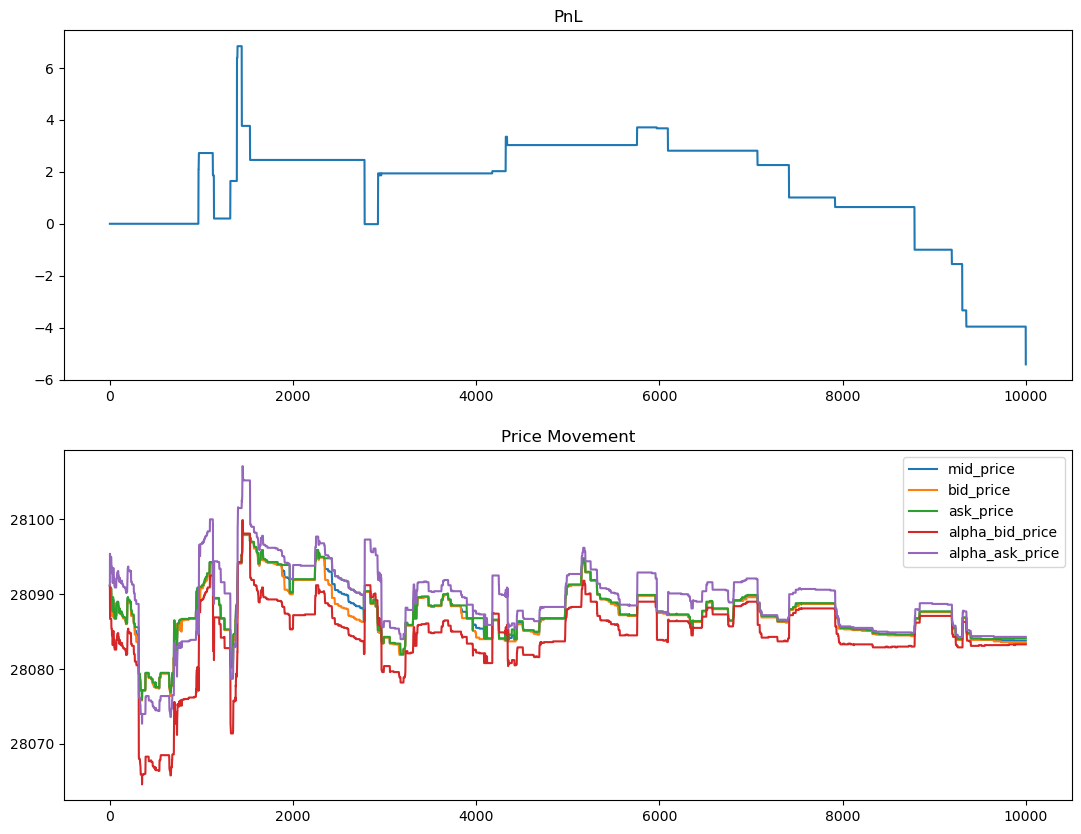

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(13, 10))

axes[0].plot(run_data['pnl_history'])
axes[0].set_title('PnL')

axes[1].plot(run_data['mid_prices'], label='mid_price')
axes[1].plot(run_data['bid_prices'], label='bid_price')
axes[1].plot(run_data['ask_prices'], label='ask_price')
axes[1].plot(run_data['my_bid_prices'], label='alpha_bid_price')
axes[1].plot(run_data['my_ask_prices'], label='alpha_ask_price')
axes[1].set_title('Price Movement')

plt.legend()
plt.show()

In [22]:
def run_simulations(alpha, num_runs: int = 10):
    profits = []
    qs = []

    for _ in range(num_runs):
        pnl_counter = PnL_Counter()
        order_book: OrderBook = OrderBook()
        agent: Agent = Agent(alpha, 0, 0)
        simulator: Simulator = Simulator(book_small, trades_small, agent, order_book, pnl_counter, alpha.T)
        run_data = simulator.run()

        profits.append(agent.USDT + agent.BTC * order_book.ask_price())
        qs.append(agent.BTC)

    return profits, qs

gridsearch for best parameters

In [26]:
t0 = 1679443200138000000
T = 1679443590529000000

best_profit = -np.inf
best_k, best_gamma = 1.5, 0.1
best_profits, best_qs = None, None

ks = [0.3, 0.5, 1]
gammas = [0.01, 0.1, 0.3]
for k, gamma in tqdm(itertools.product(ks, gammas), position=0, leave=False):
    alpha = AvellanedaStoikov(T=T, t_start=t0, q0=0, k=k, sigma=5, gamma=gamma, q_max=1)
    profits, qs = run_simulations(alpha, 10)
    mean_profit = np.mean(profits)

    if mean_profit > best_profit:
        best_profit = mean_profit
        best_k = k
        best_gamma = gamma
        best_profits = profits
        best_qs = qs

print(f'profits mean: {np.mean(best_profits)}, std: {np.std(best_profits)}')
print(f'qs mean: {np.mean(best_qs)}, std: {np.std(best_qs)}')
print(f'best params are k={best_k}, gamma={best_gamma}')

profits mean: 1.2413300000005165, std: 1.0315773456706783
qs mean: -0.5074, std: 0.4248473137493045
best params are k=0.3, gamma=0.3


Let's look at all history.

In [27]:
t0 = 1679443200138000000
T = 1679447239502340096

alpha = AvellanedaStoikov(T=T, t_start=t0, q0=0, k=best_k, 
                          sigma=10, gamma=best_gamma, q_max=1)

In [28]:
pnl_counter = PnL_Counter()
order_book: OrderBook = OrderBook()
agent: Agent = Agent(alpha, 0, 0)
simulator: Simulator = Simulator(book_small, trades_small, agent, order_book, pnl_counter, alpha.T)
run_data = simulator.run()

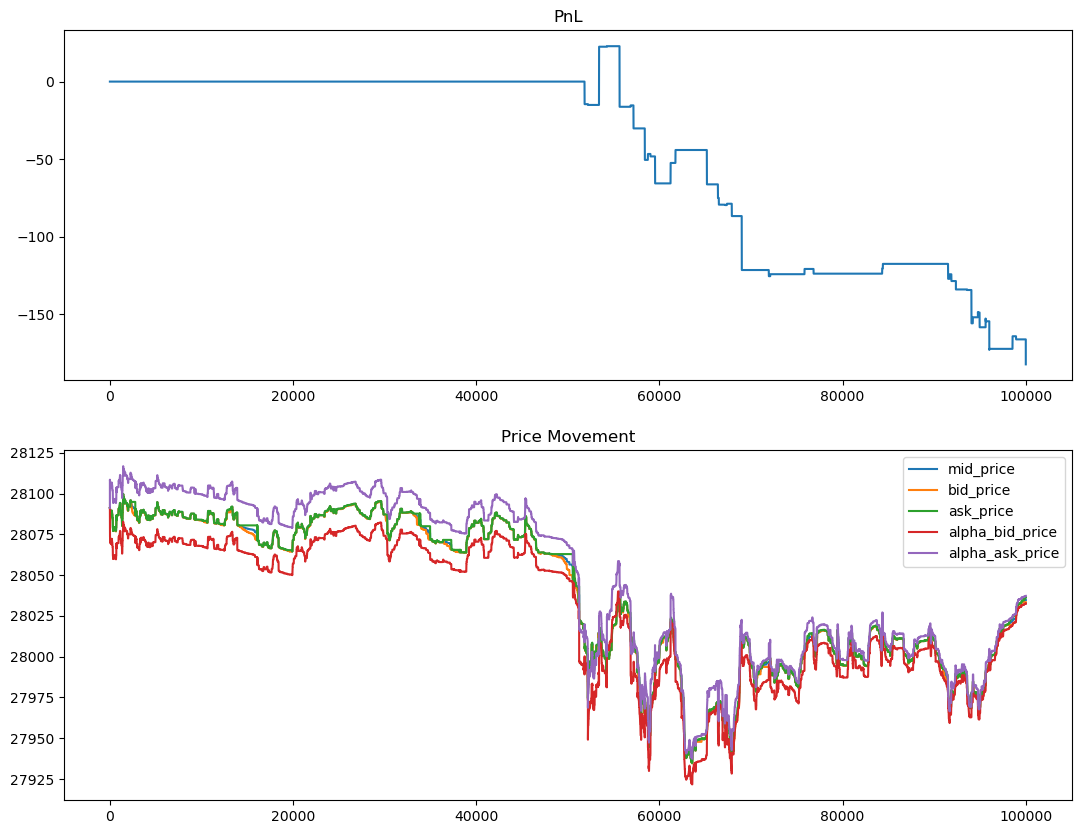

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(13, 10))

axes[0].plot(run_data['pnl_history'])
axes[0].set_title('PnL')

axes[1].plot(run_data['mid_prices'], label='mid_price')
axes[1].plot(run_data['bid_prices'], label='bid_price')
axes[1].plot(run_data['ask_prices'], label='ask_price')
axes[1].plot(run_data['my_bid_prices'], label='alpha_bid_price')
axes[1].plot(run_data['my_ask_prices'], label='alpha_ask_price')
axes[1].set_title('Price Movement')

plt.legend()
plt.show()

In [30]:
agent.BTC, agent.USDT

(-1.6770000000000003, 46846.40149999998)

In [34]:
agent.USDT + agent.BTC * order_book.bid_price()

-165.61030000002938

Not really good results)

## Improvement with Enhancing Trading Strategies with Order Book Signals

In [17]:
def lob_imbalance(bid_amount: float, ask_amount: float):
    return (bid_amount - ask_amount) / (bid_amount + ask_amount)

In [18]:
NZ: int = 5

def imbalance_to_imbalance_type(lob_imbalance: float):
    imbalance_type = (lob_imbalance + 1) / 2 * NZ
    return int(imbalance_type)

In [62]:
tick_size = 0.1
events_number = defaultdict(lambda: [0, 0, 0])
events_price_changes = defaultdict(lambda: [[], []])

last_mid_price = 28091.15
last_state = (0, 1)

for _, lob_state in tqdm(ticker_small.iterrows()):
    imbalance = lob_imbalance(lob_state['bid_amount'], lob_state['ask_amount'])
    imbalance = imbalance_to_imbalance_type(imbalance)
    delta: int = round((lob_state['ask_price'] - lob_state['bid_price']) / tick_size)

    mid_price = round((lob_state['ask_price'] + lob_state['bid_price']) / 2, 2)
    if mid_price > last_mid_price:
        events_number[last_state][1] += 1
        mid_price_change = round(mid_price - last_mid_price, 2)
        events_price_changes[last_state][0].append(mid_price_change)
    elif mid_price < last_mid_price:
        events_number[last_state][2] += 1
        mid_price_change = round(mid_price - last_mid_price, 2)
        events_price_changes[last_state][1].append(mid_price_change)
    else:
        events_number[last_state][0] += 1
    
    last_mid_price = mid_price
    last_state = (imbalance, delta)

723021it [01:08, 10497.55it/s]


In [74]:
epsilons_plus = defaultdict(int)
epsilons_minus = defaultdict(int)

for state, price_changes in tqdm(events_price_changes.items()):
    complementary_state = (NZ - state[0] - 1, state[1])
    if complementary_state in events_price_changes:
        complementary_price_changes = events_price_changes[complementary_state]
    else:
        complementary_price_changes = [[], []]
    state_events_number = events_number[state]
    if complementary_state in events_number:
        complementary_state_events_number = events_number[complementary_state]
    else:
        complementary_state_events_number = [0, 0, 0]

    sum_changes_plus = 0
    for i in price_changes[0]:
        sum_changes_plus += i
    
    sum_changes_plus_complementary = 0
    for i in complementary_price_changes[1]:
        sum_changes_plus_complementary += i
    
    if state_events_number[1] + complementary_state_events_number[2]:
        epsilons_plus[state] = (sum_changes_plus + sum_changes_plus_complementary) / \
            (state_events_number[1] + complementary_state_events_number[2])
    else:
        epsilons_plus[state] = 0
    
    sum_changes_minus = 0
    for i in price_changes[1]:
        sum_changes_minus += i
    
    sum_changes_minus_complementary = 0
    for i in complementary_price_changes[0]:
        sum_changes_minus_complementary += i
    
    if state_events_number[2] + complementary_state_events_number[1]:
        epsilons_minus[state] = (sum_changes_minus + sum_changes_minus_complementary) / \
            (state_events_number[2] + complementary_state_events_number[1])
    else:
        epsilons_minus[state] = 0


100%|██████████| 139/139 [00:00<00:00, 14635.95it/s]


In [96]:
def get_controls(lob: OrderBook):
    delta: int = round(lob.bid_ask_spread() / tick_size)
    imbalance = lob_imbalance(lob.bids[0].amount, lob.asks[0].amount)
    imbalance = imbalance_to_imbalance_type(imbalance)

    eps_bid = epsilons_plus[(imbalance, delta)]
    eps_ask = epsilons_minus[(imbalance, delta)]

    gamma_bid = int(delta / 2 > eps_bid)
    gamma_ask = int(delta / 2 > eps_ask)

    return gamma_bid, gamma_ask

In [97]:
REAL_TIMESTAMP: int = 0
LOCAL_TIMESTAMP: int = 1 # with latency

class Simulator_Enchanced(Simulator):
    def run(self):
        prev_ts = self.ts_order[0]
        last_history_lob_state: OrderBook = OrderBook().load_state(self.lob_history.iloc[self.ts_order[0][2]])
        self.order_book.load_state(self.lob_history.iloc[self.ts_order[0][2]])
        alpha_limit_orders = None
        alpha_order_ts = None
        last_alpha_ask_price, last_alpha_bid_price = self.order_book.ask_price(), self.order_book.bid_price() #hardcode. to not set new orders with same price
        memory_size = 50 # to save ts which should see our model
        order_book_memory = {i: OrderBook() for i in range(memory_size)}
        order_book_memory[0] = self.order_book
        last_trade_price = self.order_book.ask_price()
        pnl_history = [0]
        mid_prices = [self.order_book.mid_price()]
        bid_prices = [self.order_book.bid_price()]
        ask_prices = [self.order_book.ask_price()]
        my_bid_prices = [self.order_book.bid_price()]
        my_ask_prices = [self.order_book.ask_price()]

        for timestamp in tqdm(self.ts_order[1:], leave=False, position=0):
            if timestamp[0] > self.time_end:
                break
            
            limit_orders_with_ts = []
            historical_orders = self.trades_history[(self.trades_history['remote_ts'] > prev_ts[0]) & \
                                    (self.trades_history['remote_ts'] <= timestamp[0])]

            for _, order in historical_orders.iterrows():
                side = BUY if order['side'] == 'B' else SELL
                limit_order = LimitOrder(order['price'], order['amount'], side, MARKET_ID)
                last_history_lob_state.set_order(limit_order)
                limit_orders_with_ts.append((order['remote_ts'], limit_order))
        
            if timestamp[1] == REAL_TIMESTAMP:
                if timestamp[2] >= memory_size:
                    order_book_memory.pop(timestamp[2] - memory_size)
                order_book_memory[timestamp[2]] = self.order_book

                new_history_lob_state = OrderBook().load_state(self.lob_history.iloc[timestamp[2]])
                unmatched_history_orders = get_unmatched_history_orders(new_history_lob_state, last_history_lob_state)
                deleted_history_orders = get_unmatched_history_orders(last_history_lob_state, new_history_lob_state)
                cancel_history_orders(self.order_book, deleted_history_orders)
                np.random.shuffle((unmatched_history_orders))
                limit_orders_with_ts += list(map(lambda x: (timestamp[0], x), unmatched_history_orders))
                last_history_lob_state = new_history_lob_state
                
            elif timestamp[1] == LOCAL_TIMESTAMP:
                alpha_limit_orders = self.agent.set_bid_ask(order_book_memory[timestamp[2]], timestamp[0])
                alpha_order_ts = int(timestamp[0] + np.random.default_rng().exponential(scale=mean_latency))
                if alpha_limit_orders[0].price == last_alpha_bid_price and alpha_limit_orders[1].price == last_alpha_ask_price:
                    alpha_limit_orders = None
                    alpha_order_ts = None

                set_bid, set_ask = get_controls(order_book_memory[timestamp[2]])

                if not (set_bid + set_ask):
                    alpha_limit_orders = None
                else:
                    if not set_bid:
                        alpha_limit_orders[0].price = last_alpha_bid_price
                        cancel_my_bid_orders(self.order_book)
                    elif not set_ask:
                        alpha_limit_orders[1].price = last_alpha_ask_price
                        cancel_my_ask_orders(self.order_book)
            else:
                raise Exception('WRONG TIMESTAMP')
            
            if alpha_limit_orders is not None:
                if alpha_order_ts < timestamp[0]:
                    index = 0
                    for i, (ts, limit_order) in enumerate(limit_orders_with_ts):
                        if ts > alpha_order_ts:
                            index = i
                            break
                    
                    if alpha_limit_orders[0].price != last_alpha_bid_price:
                        limit_orders_with_ts.insert(index, (alpha_order_ts, alpha_limit_orders[0]))
                        last_alpha_bid_price = alpha_limit_orders[0].price
                    if alpha_limit_orders[1].price != last_alpha_ask_price:
                        limit_orders_with_ts.insert(index, (alpha_order_ts, alpha_limit_orders[1]))
                        last_alpha_ask_price = alpha_limit_orders[1].price
                    
                    alpha_limit_orders = None
                    alpha_order_ts = None
            
            for (_, limit_order) in limit_orders_with_ts:
                if limit_order.trader_id == MM_ID:
                    if limit_order.side == BUY:
                        cancel_my_bid_orders(self.order_book)
                    elif limit_order.side == SELL:
                        cancel_my_ask_orders(self.order_book)

                match_info = self.order_book.set_order(limit_order)
                
                if MM_ID in match_info:
                    self.pnl_counter.change_pnl(last_trade_price, self.order_book.ask_price(), self.agent.BTC)
                    
                    MM_data = match_info[MM_ID]
                    if limit_order.side == BUY:
                        self.agent.BTC -= MM_data[0]
                        self.agent.USDT += MM_data[1]
                        #self.pnl_counter.realized_pnl(MM_data[0], MM_data[1])
                    elif limit_order.side == SELL:
                        self.agent.BTC += MM_data[0]
                        self.agent.USDT -= MM_data[1]
                        #self.pnl_counter.update(MM_data[0], MM_data[1])
                    else:
                        raise Exception('ERROR SIDE')
                    
                    last_trade_price = self.order_book.ask_price()
            
            if timestamp[1] == REAL_TIMESTAMP:
                pnl_history.append(self.pnl_counter.pnl)
                if len(self.order_book.get_bids()) and len(self.order_book.get_asks()):
                    mid_prices.append(self.order_book.mid_price())
                else:
                    mid_prices.append(mid_prices[-1])
                
                if len(self.order_book.get_bids()):
                    bid_prices.append(self.order_book.bid_price())
                else:
                    bid_prices.append(bid_prices[-1])
                
                if len(self.order_book.get_asks()):
                    ask_prices.append(self.order_book.ask_price())
                else:
                    ask_prices.append(ask_prices[-1])
                my_bid_prices.append(last_alpha_bid_price)
                my_ask_prices.append(last_alpha_ask_price)
            #self.pnl_counter.unrealized_pnl(self.agent.BTC, self.order_book.ask_price())
            prev_ts = timestamp
        self.pnl_counter.change_pnl(last_trade_price, self.order_book.ask_price(), self.agent.BTC)
        pnl_history.append(self.pnl_counter.pnl)

        return {'pnl_history': pnl_history, 'mid_prices': mid_prices,
               'bid_prices': bid_prices, 'ask_prices': ask_prices,
               'my_bid_prices': my_bid_prices, 'my_ask_prices': my_ask_prices}

In [101]:
t0 = 1679443200138000000
T = 1679447239502340096

pnl_counter = PnL_Counter()
order_book: OrderBook = OrderBook()
alpha = AvellanedaStoikov(T=T, t_start=t0, q0=0, k=0.3, sigma=10, gamma=0.3, q_max=1)
agent: Agent = Agent(alpha, 0, 0)
simulator: Simulator_Enchanced = Simulator_Enchanced(book_small, trades_small, agent, order_book, pnl_counter, T)

In [102]:
run_data = simulator.run()

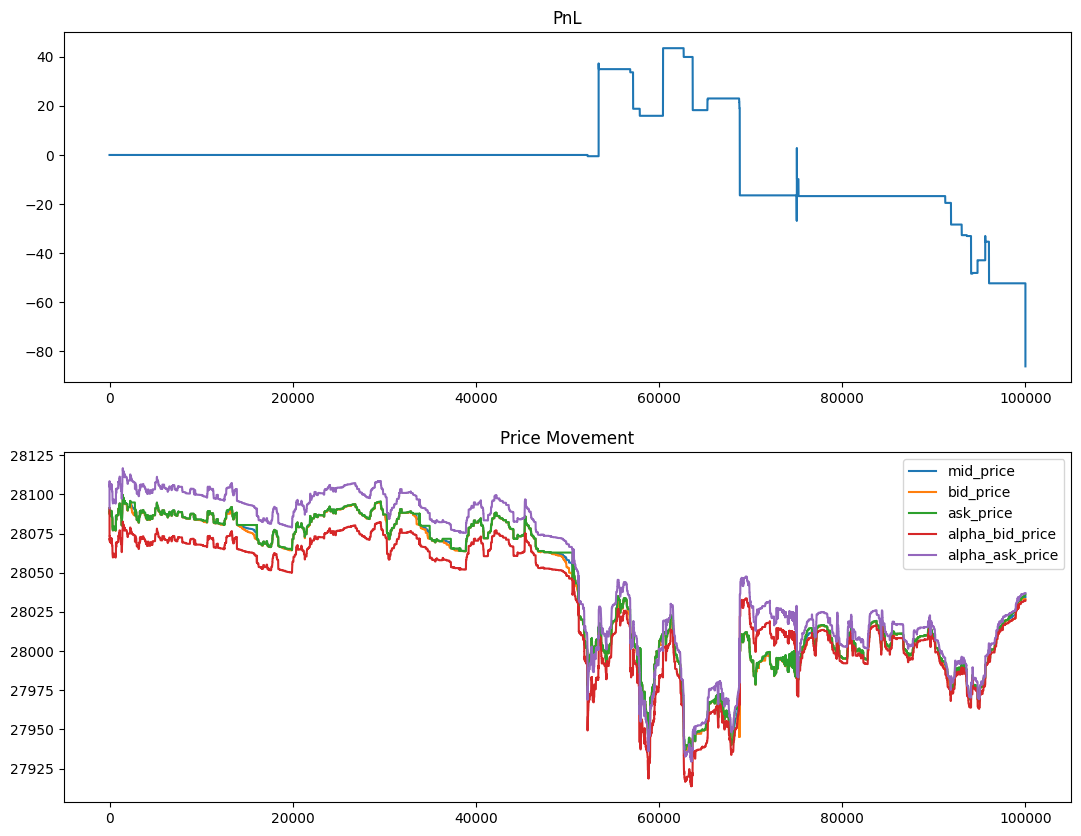

In [103]:
fig, axes = plt.subplots(2, 1, figsize=(13, 10))

axes[0].plot(run_data['pnl_history'])
axes[0].set_title('PnL')

axes[1].plot(run_data['mid_prices'], label='mid_price')
axes[1].plot(run_data['bid_prices'], label='bid_price')
axes[1].plot(run_data['ask_prices'], label='ask_price')
axes[1].plot(run_data['my_bid_prices'], label='alpha_bid_price')
axes[1].plot(run_data['my_ask_prices'], label='alpha_ask_price')
axes[1].set_title('Price Movement')

plt.legend()
plt.show()

In [104]:
agent.BTC, agent.USDT

(-0.9269999999999999, 25953.343999999983)

In [105]:
agent.BTC * order_book.ask_price() + agent.USDT

-36.2134000000151

### Why I used exponential distribution for latency simulating

In [122]:
lat_mean = (book_small.local_timestamp - book_small.timestamp).values.mean()
lat_std = (book_small.local_timestamp - book_small.timestamp).values.std()
lat = (book_small.local_timestamp - book_small.timestamp).values

In [132]:
lat_part = lat[(lat > lat_mean - 1.96 * lat_std) & (lat < lat_mean + 1.96 * lat_std)]

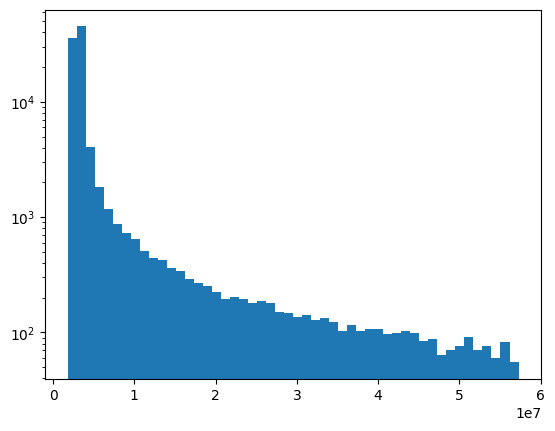

In [135]:
plt.hist(lat_part, bins=50)
plt.yscale('log')
plt.show()